## Machine Learning

In [ ]:
pip install Datasets

{'Logistic Regression': {'Precision': 0.700625, 'Accuracy': 0.65, 'F1-Score': 0.6150039277297722}, 'Linear SVC': {'Precision': 0.6245496323529413, 'Accuracy': 0.62, 'F1-Score': 0.607477769641176}, 'Random Forest': {'Precision': 0.650408483896308, 'Accuracy': 0.645, 'F1-Score': 0.6352852205098884}}


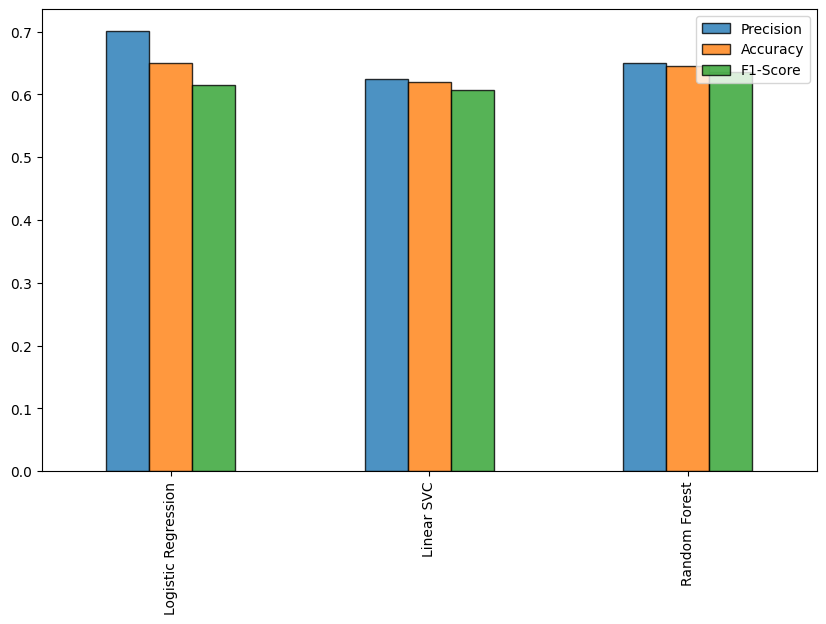

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud

data = pd.read_csv('updated_data_with_turkish_sentiment.csv')

texts = data['normalized_text']
labels = data['turkish_sentiment_label']

label_map = {'positive': 1, 'negative': 0}
y = labels.map(label_map)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=42)

# Custom list of Turkish stop words
turkish_stop_words = [
    "bir", "ve", "bu", "da", "de", "için", "ile", "ama", "gibi", "diye",
    "ki", "şu", "o", "ne", "çok", "daha", "mi", "mu", "mi", "mı", "her",
    "kendi", "sen", "ben", "biz", "siz", "onlar", "bu", "şimdi", "şey",
    "kim", "bunun", "olarak", "vardır", "oldu", "içinde", "herkes",
    "bizim", "bir şey", "olması", "olabilir", "olarak", "şöyle", "şunlar"
]

# Feature extraction: Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words=turkish_stop_words)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVC": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    predictions = model.predict(X_test_tfidf)
    results[model_name] = classification_report(y_test, predictions, output_dict=True)

# Extract precision, accuracy, and F1-score for each model
evaluation_summary = {
    model_name: {
        "Precision": metrics["weighted avg"]["precision"],
        "Accuracy": metrics["accuracy"],
        "F1-Score": metrics["weighted avg"]["f1-score"],
    }
    for model_name, metrics in results.items()
}

print(evaluation_summary)

# Convert to DataFrame for better readability
evaluation_summary_df = pd.DataFrame(evaluation_summary).T

# Visualization of model performance
evaluation_summary_df.plot(kind='bar', figsize=(10, 6), alpha=0.8, edgecolor='black')

positive_texts = ' '.join(texts[labels == 'positive'])
negative_texts = ' '.join(texts[labels == 'negative'])

wordcloud_positive = WordCloud(stopwords=turkish_stop_words, background_color='white', colormap='Blues', width=800, height=400).generate(positive_texts)
wordcloud_negative = WordCloud(stopwords=turkish_stop_words, background_color='white', colormap='Reds', width=800, height=400).generate(negative_texts)


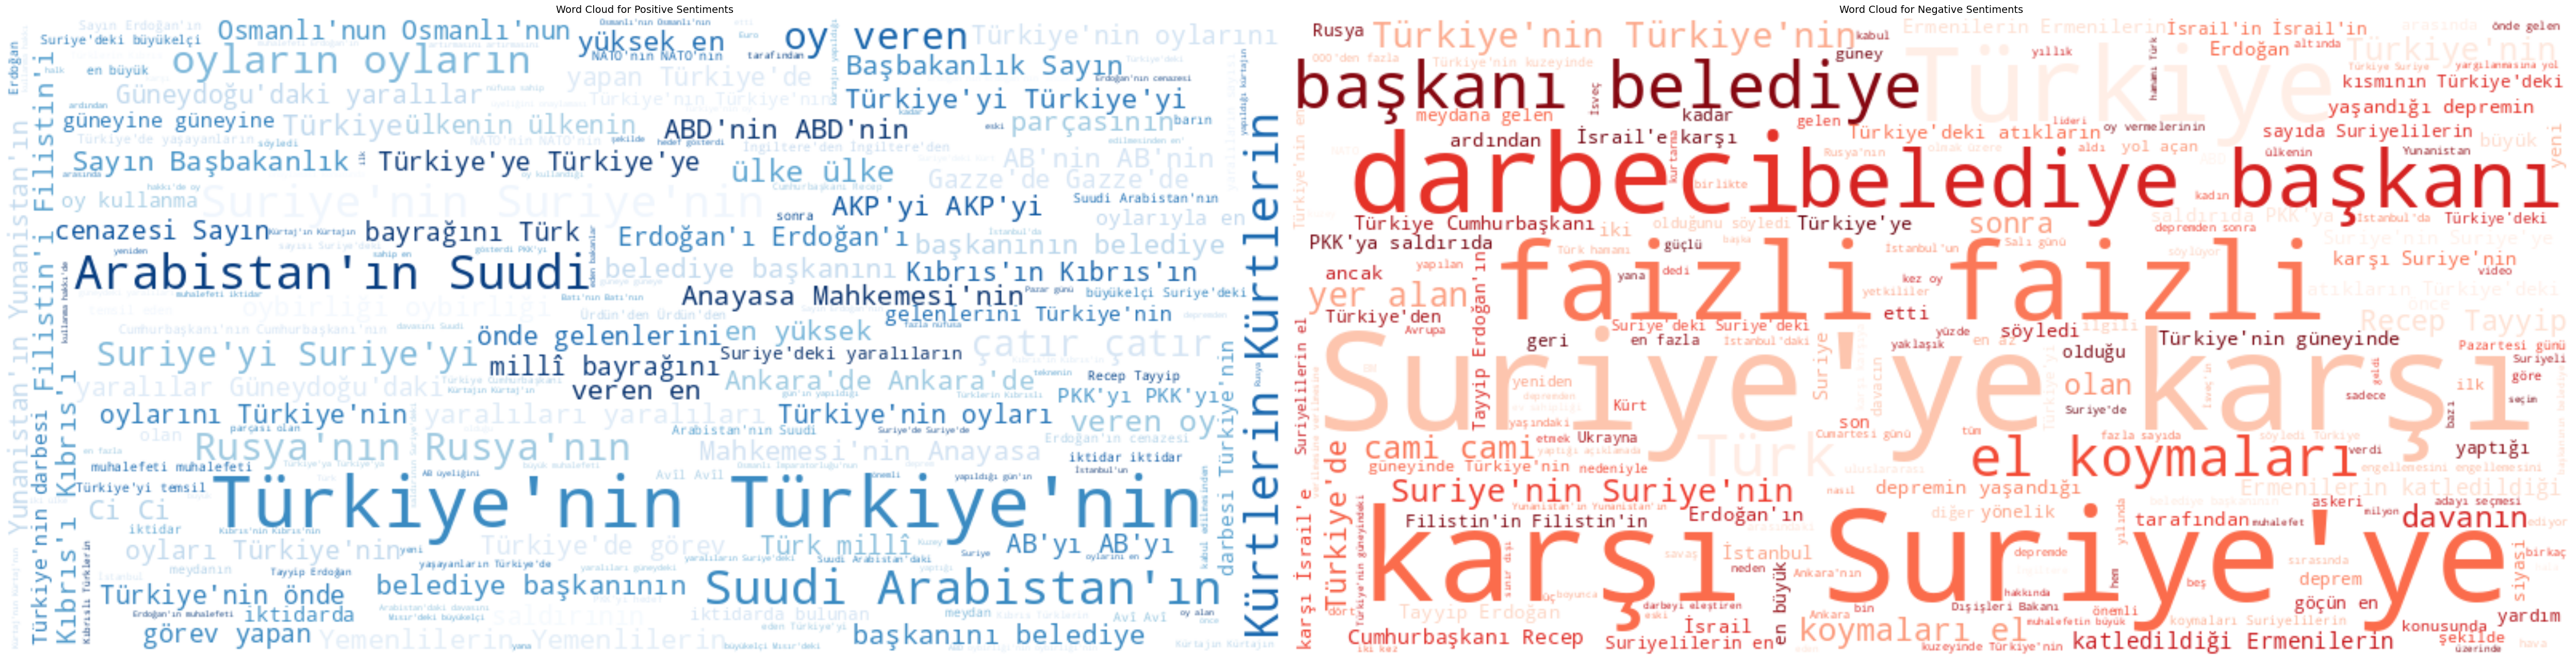

In [ ]:
plt.figure(figsize=(50, 50))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title("Word Cloud for Positive Sentiments", fontsize=14)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title("Word Cloud for Negative Sentiments", fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
positive_examples = data[data['turkish_sentiment_label'] == 'positive']['normalized_text'].head(1)
negative_examples = data[data['turkish_sentiment_label'] == 'negative']['normalized_text'].head(1)

positive_examples_list = positive_examples.tolist()
negative_examples_list = negative_examples.tolist()

positive_examples_list,"\n", negative_examples_list


(["Roberts, Kompany'yi gelecekte antrenör olarak taklit etmeyi hedefliyor. Pazartesi günü Türkiye'de Euro 2024 eleme maçında Galler'in kadrosunda yer alan Roberts, geleceğin Belediye patronu olarak bahşiş verdiği Belçikalı'yı taklit etmek istiyor. Şimdi Almanya'da gelecek yaz turnuvasına ulaşmak için tekliflerini canlandırmayı umarak Pazartesi günü D Grubu liderleri Türkiye'ye seyahat ediyorlar. Roberts, Galler'in 2021'de Euro 2020'de Türkiye ile buluştuğunda puan aldı ve Azerbaycan'da Galler'in yerini uzun bir yoldan nakavt etapta güvence altına aldı."],
 '\n',
 ["Tehlikedeki diller hakkında Guardian görüşü: birkaç kişi tarafından konuşuldu, ancak birçok kişi için değerli. Türkiye'nin Karadeniz kıyısındaki dağ köylerinde yaşayan birkaç bin nüfus tarafından konuşulan Romeyka, binlerce yıl önce modern Yunan'dan ayrıldı."])

## Zero Shot Bart

Device set to use cuda:0


Accuracy: 0.64
Precision (Positive): 0.62
Recall (Positive): 0.91
F1-score (Positive): 0.74


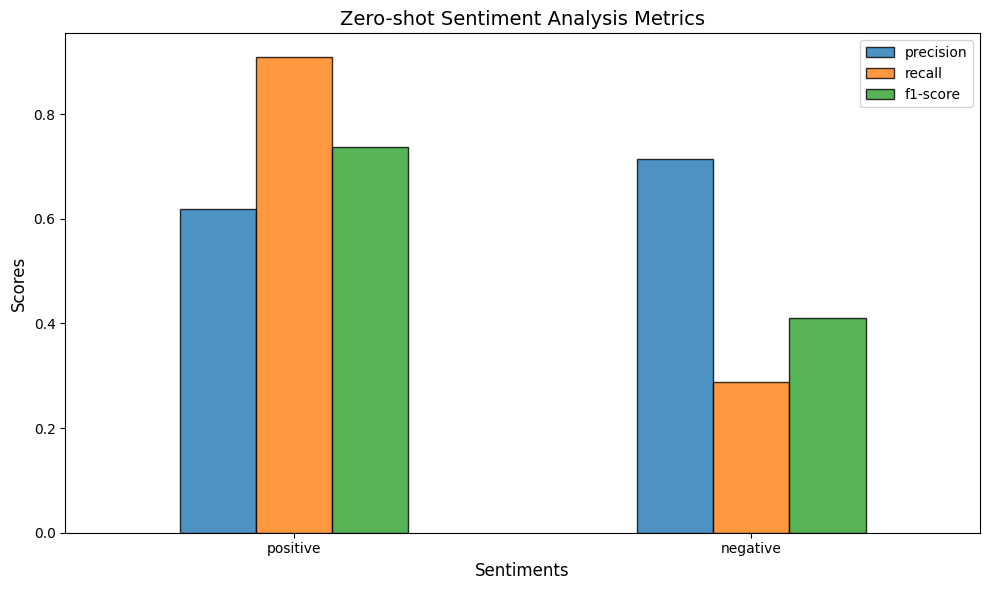

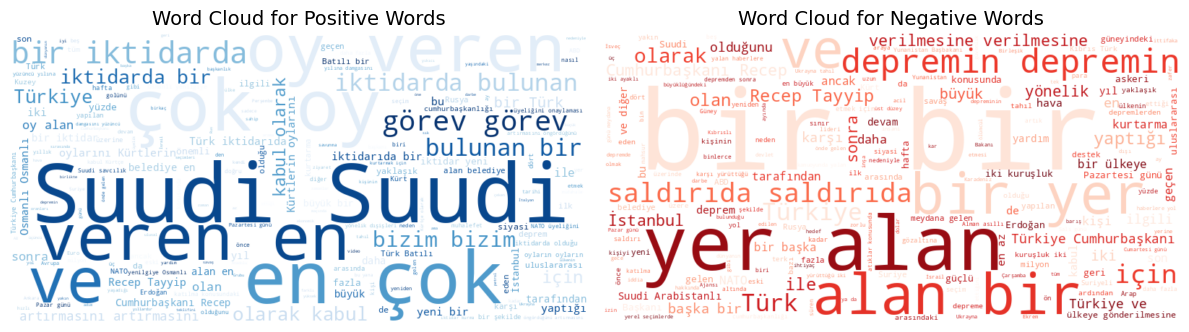

Neutral Words (Shared between Positive and Negative):
[('Roma', 1), ('başka', 1), ('dolayı', 1), ('yapmak', 1), ('bunun', 1), ('kapalı', 1), ('Devlet', 1), ('kadının', 1), ('hasta', 1), ('aile', 1)]


In [ ]:
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from collections import Counter

# Load dataset
data = pd.read_csv('updated_data_with_turkish_sentiment.csv')

# Filter a small sample for testing
texts = data['normalized_text']
true_labels = data['turkish_sentiment_label'].map({'positive': 'positive', 'negative': 'negative'})

# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define candidate labels for sentiment analysis
candidate_labels = ["positive", "negative"]

# Perform classification
predicted_labels = []
for text in texts:
    result = classifier(text, candidate_labels)
    predicted_labels.append(result['labels'][0])  # Take the top label

# Evaluate the performance
report = classification_report(true_labels, predicted_labels, target_names=candidate_labels, output_dict=True)

# Display metrics
accuracy = report["accuracy"]
precision_positive = report["positive"]["precision"]
recall_positive = report["positive"]["recall"]
f1_positive = report["positive"]["f1-score"]

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Positive): {precision_positive:.2f}")
print(f"Recall (Positive): {recall_positive:.2f}")
print(f"F1-score (Positive): {f1_positive:.2f}")

# Convert the classification report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Visualization of precision, recall, and F1-score
metrics = report_df.loc[["positive", "negative"], ["precision", "recall", "f1-score"]]
metrics.plot(kind='bar', figsize=(10, 6), alpha=0.8, edgecolor='black')

# Add labels and title
plt.title("Zero-shot Sentiment Analysis Metrics", fontsize=14)
plt.xlabel("Sentiments", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.xticks(rotation=0)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

# Extract words for positive and negative texts
positive_texts = ' '.join(data[data['turkish_sentiment_label'] == 'positive']['normalized_text'][:100])
negative_texts = ' '.join(data[data['turkish_sentiment_label'] == 'negative']['normalized_text'][:100])

positive_words = [word for word in positive_texts.split() if word.isalpha()]
negative_words = [word for word in negative_texts.split() if word.isalpha()]

# Generate word clouds for positive and negative words
wordcloud_positive = WordCloud(background_color='white', colormap='Blues', width=800, height=400).generate(' '.join(positive_words))
wordcloud_negative = WordCloud(background_color='white', colormap='Reds', width=800, height=400).generate(' '.join(negative_words))

# Plot word clouds
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title("Word Cloud for Positive Words", fontsize=14)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title("Word Cloud for Negative Words", fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

# Identify overlapping words (neutral words)
neutral_words = set(positive_words).intersection(set(negative_words))
neutral_word_counts = Counter(word for word in neutral_words if len(word) > 3)  # Filter meaningful neutral words

# Display top overlapping words
print("Neutral Words (Shared between Positive and Negative):")
print(neutral_word_counts.most_common(10))


In [ ]:
# Perform classification
predicted_labels = []
specific_sentences = [
    "SEDS 539 çok güzel bir ders.",
    "Covid-19 Pandemisi 2021'de gerçekleşti.",
    "Türkiye'nin doğal güzellikleri ve tarihi dokusu dünyanın her yerinden turistleri çekiyor, bu da ülke ekonomisine olumlu bir katkı sağlıyor.",
    "Ekonomideki sıkıntılar nedeniyle vatandaşlar her geçen gün daha da zor bir yaşam sürmek zorunda kalıyor, bu da halkın moralini olumsuz etkiliyor.",
    "Hükümetin eğitim ve sağlık alanındaki reformları, toplumun genel refah seviyesini artırmayı hedefliyor ve bu alanlarda gözle görülür iyileşmeler sağlıyor.",
    "Son yıllarda artan doğal afetler ve çevre kirliliği, ülke genelinde ciddi endişelere yol açtı ve birçok insanın yaşamını olumsuz etkiledi.",
    "Teknolojik gelişmeler ve yenilikçi projeler sayesinde ülke ekonomisinin hızlı bir şekilde toparlanması bekleniyor."
]

specific_results = []

for text in texts:
    result = classifier(text, candidate_labels)
    predicted_labels.append(result['labels'][0])  # Take the top label

# Perform sentiment analysis for specific sentences
for sentence in specific_sentences:
    result = classifier(sentence, candidate_labels)
    specific_results.append((sentence, result['labels'][0], result['scores'][0]))  # Sentence, label, confidence

specific_results

[('SEDS 539 çok güzel bir ders.', 'negative', 0.8431205153465271),
 ("Covid-19 Pandemisi 2021'de gerçekleşti.", 'negative', 0.6152039766311646),
 ("Türkiye'nin doğal güzellikleri ve tarihi dokusu dünyanın her yerinden turistleri çekiyor, bu da ülke ekonomisine olumlu bir katkı sağlıyor.",
  'positive',
  0.9245755672454834),
 ('Ekonomideki sıkıntılar nedeniyle vatandaşlar her geçen gün daha da zor bir yaşam sürmek zorunda kalıyor, bu da halkın moralini olumsuz etkiliyor.',
  'positive',
  0.6502447724342346),
 ('Hükümetin eğitim ve sağlık alanındaki reformları, toplumun genel refah seviyesini artırmayı hedefliyor ve bu alanlarda gözle görülür iyileşmeler sağlıyor.',
  'negative',
  0.6490011811256409),
 ('Son yıllarda artan doğal afetler ve çevre kirliliği, ülke genelinde ciddi endişelere yol açtı ve birçok insanın yaşamını olumsuz etkiledi.',
  'negative',
  0.690907895565033),
 ('Teknolojik gelişmeler ve yenilikçi projeler sayesinde ülke ekonomisinin hızlı bir şekilde toparlanması be

 ## Bert Fine Tune

In [ ]:
pip install Dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
import torch

# Load dataset
data = pd.read_csv('updated_data_with_turkish_sentiment.csv')

# Prepare dataset for training
texts = data['normalized_text']
labels = data['turkish_sentiment_label'].map({'positive': 1, 'negative': 0})

# Split dataset into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset format
def create_hf_dataset(texts, labels):
    return Dataset.from_dict({"text": texts, "label": labels})

train_dataset = create_hf_dataset(train_texts.tolist(), train_labels.tolist())
test_dataset = create_hf_dataset(test_texts.tolist(), test_labels.tolist())

# Initialize tokenizer and model
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])
train_dataset = train_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    eval_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Define metrics
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    return classification_report(pred.label_ids, preds, output_dict=True)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Evaluate the model
evaluation_results = trainer.evaluate()
print("Evaluation Results:")
print(evaluation_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-2e8aff20cce2>:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer is attempting to log a value of "{'precision': 0.71900826446281, 'recall': 0.8207547169811321, 'f1-score': 0.7665198237885462, 'support': 106.0}" of type <class 'dict'> for key "eval/0" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.759493670886076, 'recall': 0.6382978723404256, 'f1-score': 0.6936416184971098, 'support': 94.0}" of type <class 'dict'> for key "eval/1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.739250967674443, 'recall': 0.7295262946607788, 'f1-score': 0.730080721142828, 'support': 200.0}" of type <class 'dict'> for key "eval/macro avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.7380364054817451, 'recall'

Evaluation Results:
{'eval_loss': 0.5426232814788818, 'eval_0': {'precision': 0.71900826446281, 'recall': 0.8207547169811321, 'f1-score': 0.7665198237885462, 'support': 106.0}, 'eval_1': {'precision': 0.759493670886076, 'recall': 0.6382978723404256, 'f1-score': 0.6936416184971098, 'support': 94.0}, 'eval_accuracy': 0.735, 'eval_macro avg': {'precision': 0.739250967674443, 'recall': 0.7295262946607788, 'f1-score': 0.730080721142828, 'support': 200.0}, 'eval_weighted avg': {'precision': 0.7380364054817451, 'recall': 0.735, 'f1-score': 0.7322670673015711, 'support': 200.0}, 'eval_runtime': 6.1116, 'eval_samples_per_second': 32.724, 'eval_steps_per_second': 2.127, 'epoch': 3.0}


In [ ]:
# Test the model on specific sentences
specific_sentences = [
    "SEDS 539 çok güzel bir ders.",
    "Covid-19 Pandemisi 2021'de gerçekleşti.",
    "Türkiye'nin doğal güzellikleri ve tarihi dokusu dünyanın her yerinden turistleri çekiyor, bu da ülke ekonomisine olumlu bir katkı sağlıyor.",
    "Ekonomideki sıkıntılar nedeniyle vatandaşlar her geçen gün daha da zor bir yaşam sürmek zorunda kalıyor, bu da halkın moralini olumsuz etkiliyor.",
    "Hükümetin eğitim ve sağlık alanındaki reformları, toplumun genel refah seviyesini artırmayı hedefliyor ve bu alanlarda gözle görülür iyileşmeler sağlıyor.",
    "Son yıllarda artan doğal afetler ve çevre kirliliği, ülke genelinde ciddi endişelere yol açtı ve birçok insanın yaşamını olumsuz etkiledi.",
    "Teknolojik gelişmeler ve yenilikçi projeler sayesinde ülke ekonomisinin hızlı bir şekilde toparlanması bekleniyor."
]

specific_results = []
for sentence in specific_sentences:
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()[0]
    predicted_label = scores.argmax()
    confidence = scores.max()
    specific_results.append((sentence, "positive" if predicted_label == 1 else "negative", confidence))

print("\nSentiment Analysis for Specific Sentences:")
for sentence, label, confidence in specific_results:
    print(f"Sentence: '{sentence}'\nPredicted Sentiment: {label} (Confidence: {confidence:.2f})\n")


Sentiment Analysis for Specific Sentences:
Sentence: 'SEDS 539 çok güzel bir ders.'
Predicted Sentiment: positive (Confidence: 0.57)

Sentence: 'Covid-19 Pandemisi 2021'de gerçekleşti.'
Predicted Sentiment: positive (Confidence: 0.56)

Sentence: 'Türkiye'nin doğal güzellikleri ve tarihi dokusu dünyanın her yerinden turistleri çekiyor, bu da ülke ekonomisine olumlu bir katkı sağlıyor.'
Predicted Sentiment: negative (Confidence: 0.50)

Sentence: 'Ekonomideki sıkıntılar nedeniyle vatandaşlar her geçen gün daha da zor bir yaşam sürmek zorunda kalıyor, bu da halkın moralini olumsuz etkiliyor.'
Predicted Sentiment: negative (Confidence: 0.55)

Sentence: 'Hükümetin eğitim ve sağlık alanındaki reformları, toplumun genel refah seviyesini artırmayı hedefliyor ve bu alanlarda gözle görülür iyileşmeler sağlıyor.'
Predicted Sentiment: negative (Confidence: 0.65)

Sentence: 'Son yıllarda artan doğal afetler ve çevre kirliliği, ülke genelinde ciddi endişelere yol açtı ve birçok insanın yaşamını olum

## Bert without Fine Tune

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Define specific sentences for inference
specific_sentences = [
    "SEDS 539 çok güzel bir ders.",
    "Covid-19 Pandemisi 2021'de gerçekleşti.",
    "Türkiye'nin doğal güzellikleri ve tarihi dokusu dünyanın her yerinden turistleri çekiyor, bu da ülke ekonomisine olumlu bir katkı sağlıyor.",
    "Ekonomideki sıkıntılar nedeniyle vatandaşlar her geçen gün daha da zor bir yaşam sürmek zorunda kalıyor, bu da halkın moralini olumsuz etkiliyor.",
    "Hükümetin eğitim ve sağlık alanındaki reformları, toplumun genel refah seviyesini artırmayı hedefliyor ve bu alanlarda gözle görülür iyileşmeler sağlıyor.",
    "Son yıllarda artan doğal afetler ve çevre kirliliği, ülke genelinde ciddi endişelere yol açtı ve birçok insanın yaşamını olumsuz etkiledi.",
    "Teknolojik gelişmeler ve yenilikçi projeler sayesinde ülke ekonomisinin hızlı bir şekilde toparlanması bekleniyor."
]

# Initialize tokenizer and model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Perform inference
def predict(texts):
    predictions = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()[0]
        predicted_label = np.argmax(scores)
        confidence = scores[predicted_label]
        predictions.append((predicted_label, confidence))
    return predictions

# Predict on specific sentences
predictions = predict(specific_sentences)

# Display predictions
for i, (text, (label, confidence)) in enumerate(zip(specific_sentences, predictions)):
    sentiment = "positive" if label > 2 else "negative"
    print(f"Sentence {i + 1}: {text}\nPredicted Sentiment: {sentiment} (Confidence: {confidence:.2f})\n")

Sentence 1: SEDS 539 çok güzel bir ders.
Predicted Sentiment: positive (Confidence: 0.68)

Sentence 2: Covid-19 Pandemisi 2021'de gerçekleşti.
Predicted Sentiment: negative (Confidence: 0.45)

Sentence 3: Türkiye'nin doğal güzellikleri ve tarihi dokusu dünyanın her yerinden turistleri çekiyor, bu da ülke ekonomisine olumlu bir katkı sağlıyor.
Predicted Sentiment: positive (Confidence: 0.62)

Sentence 4: Ekonomideki sıkıntılar nedeniyle vatandaşlar her geçen gün daha da zor bir yaşam sürmek zorunda kalıyor, bu da halkın moralini olumsuz etkiliyor.
Predicted Sentiment: negative (Confidence: 0.26)

Sentence 5: Hükümetin eğitim ve sağlık alanındaki reformları, toplumun genel refah seviyesini artırmayı hedefliyor ve bu alanlarda gözle görülür iyileşmeler sağlıyor.
Predicted Sentiment: positive (Confidence: 0.41)

Sentence 6: Son yıllarda artan doğal afetler ve çevre kirliliği, ülke genelinde ciddi endişelere yol açtı ve birçok insanın yaşamını olumsuz etkiledi.
Predicted Sentiment: negative

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Load dataset
data = pd.read_csv('/content/updated_data_with_turkish_sentiment.csv')

# Extract texts and true labels
texts = data['normalized_text'].tolist()
true_labels = data['turkish_sentiment_label'].map({'positive': 4, 'neutral': 2, 'negative': 0}).tolist()

# Initialize tokenizer and model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Perform inference
def predict(texts):
    predictions = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()[0]
        predicted_label = np.argmax(scores)
        confidence = scores[predicted_label]
        predictions.append((predicted_label, confidence))
    return predictions

# Predict on the dataset
predictions = predict(texts)

# Extract predicted labels
predicted_labels = [pred[0] for pred in predictions]

# Map predicted labels to sentiment categories for display
sentiment_map = {0: "negative", 1: "neutral", 2: "neutral", 3: "positive", 4: "positive"}

# Adjust predicted labels to match available target names
adjusted_true_labels = [sentiment_map[label] for label in true_labels]
adjusted_predicted_labels = [sentiment_map[label] for label in predicted_labels]

# Calculate and display classification metrics
print("Classification Report:")
report = classification_report(adjusted_true_labels, adjusted_predicted_labels, target_names=["negative", "neutral", "positive"], zero_division=0)
print(report)


Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.73      0.68       560
     neutral       0.00      0.00      0.00         0
    positive       0.64      0.31      0.42       440

    accuracy                           0.55      1000
   macro avg       0.43      0.35      0.37      1000
weighted avg       0.64      0.55      0.56      1000



## cardiffnlp Fine Tune

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Define specific sentences for inference
specific_sentences = [
    "SEDS 539 çok güzel bir ders.",
    "Covid-19 Pandemisi 2021'de gerçekleşti.",
    "Türkiye'nin doğal güzellikleri ve tarihi dokusu dünyanın her yerinden turistleri çekiyor, bu da ülke ekonomisine olumlu bir katkı sağlıyor.",
    "Ekonomideki sıkıntılar nedeniyle vatandaşlar her geçen gün daha da zor bir yaşam sürmek zorunda kalıyor, bu da halkın moralini olumsuz etkiliyor.",
    "Hükümetin eğitim ve sağlık alanındaki reformları, toplumun genel refah seviyesini artırmayı hedefliyor ve bu alanlarda gözle görülür iyileşmeler sağlıyor.",
    "Son yıllarda artan doğal afetler ve çevre kirliliği, ülke genelinde ciddi endişelere yol açtı ve birçok insanın yaşamını olumsuz etkiledi.",
    "Teknolojik gelişmeler ve yenilikçi projeler sayesinde ülke ekonomisinin hızlı bir şekilde toparlanması bekleniyor."
]

# Prepare dataset for few-shot learning
import pandas as pd

data = pd.read_csv('updated_data_with_turkish_sentiment.csv')
texts = data['normalized_text']
labels = data['turkish_sentiment_label'].map({'positive': 2, 'neutral': 1, 'negative': 0})  # Adjust labels for 3-class sentiment

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset format
def create_hf_dataset(texts, labels):
    return Dataset.from_dict({"text": texts, "label": labels})

train_dataset = create_hf_dataset(train_texts[:50].tolist(), train_labels[:50].tolist())  # Few-shot: Use small subset
test_dataset = create_hf_dataset(test_texts.tolist(), test_labels.tolist())

# Initialize tokenizer and model for sentiment analysis
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])
train_dataset = train_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")

# Fine-tune the model
training_args = TrainingArguments(
    output_dir="./results_multilingual_sentiment",
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    eval_steps=500,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Define metrics
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(pred.label_ids, preds, average='weighted')
    acc = accuracy_score(pred.label_ids, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Uncomment the following line to fine-tune the model
trainer.train()

# Perform inference on specific sentences without fine-tuning
def predict(texts):
    predictions = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()[0]
        predicted_label = np.argmax(scores)
        confidence = scores[predicted_label]
        predictions.append((predicted_label, confidence))
    return predictions

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Predict on specific sentences
predictions = predict(specific_sentences)

# Map predicted labels to sentiment
sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}

# Display predictions
for i, (text, (label, confidence)) in enumerate(zip(specific_sentences, predictions)):
    sentiment = sentiment_map[label]
    print(f"Sentence {i + 1}: {text}\nPredicted Sentiment: {sentiment} (Confidence: {confidence:.2f})\n")


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-56-5e77b8fffd8b>:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Sentence 1: SEDS 539 çok güzel bir ders.
Predicted Sentiment: positive (Confidence: 1.00)

Sentence 2: Covid-19 Pandemisi 2021'de gerçekleşti.
Predicted Sentiment: positive (Confidence: 0.93)

Sentence 3: Türkiye'nin doğal güzellikleri ve tarihi dokusu dünyanın her yerinden turistleri çekiyor, bu da ülke ekonomisine olumlu bir katkı sağlıyor.
Predicted Sentiment: positive (Confidence: 1.00)

Sentence 4: Ekonomideki sıkıntılar nedeniyle vatandaşlar her geçen gün daha da zor bir yaşam sürmek zorunda kalıyor, bu da halkın moralini olumsuz etkiliyor.
Predicted Sentiment: negative (Confidence: 1.00)

Sentence 5: Hükümetin eğitim ve sağlık alanındaki reformları, toplumun genel refah seviyesini artırmayı hedefliyor ve bu alanlarda gözle görülür iyileşmeler sağlıyor.
Predicted Sentiment: positive (Confidence: 0.99)

Sentence 6: Son yıllarda artan doğal afetler ve çevre kirliliği, ülke genelinde ciddi endişelere yol açtı ve birçok insanın yaşamını olumsuz etkiledi.
Predicted Sentiment: negative

In [ ]:
# Evaluate the model
evaluation_results = trainer.evaluate()

# Display evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {evaluation_results['eval_accuracy']:.2f}")
print(f"Precision: {evaluation_results['eval_precision']:.2f}")
print(f"Recall: {evaluation_results['eval_recall']:.2f}")
print(f"F1-score: {evaluation_results['eval_f1']:.2f}")


Evaluation Metrics:
Accuracy: 0.70
Precision: 0.72
Recall: 0.70
F1-score: 0.69


## cardiffnlp Without Fine Tune

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Define specific sentences for inference
specific_sentences = [
    "SEDS 539 çok güzel bir ders.",
    "Covid-19 Pandemisi 2021'de gerçekleşti.",
    "Türkiye'nin doğal güzellikleri ve tarihi dokusu dünyanın her yerinden turistleri çekiyor, bu da ülke ekonomisine olumlu bir katkı sağlıyor.",
    "Ekonomideki sıkıntılar nedeniyle vatandaşlar her geçen gün daha da zor bir yaşam sürmek zorunda kalıyor, bu da halkın moralini olumsuz etkiliyor.",
    "Hükümetin eğitim ve sağlık alanındaki reformları, toplumun genel refah seviyesini artırmayı hedefliyor ve bu alanlarda gözle görülür iyileşmeler sağlıyor.",
    "Son yıllarda artan doğal afetler ve çevre kirliliği, ülke genelinde ciddi endişelere yol açtı ve birçok insanın yaşamını olumsuz etkiledi.",
    "Teknolojik gelişmeler ve yenilikçi projeler sayesinde ülke ekonomisinin hızlı bir şekilde toparlanması bekleniyor."
]

# Prepare dataset for few-shot learning
import pandas as pd

data = pd.read_csv('updated_data_with_turkish_sentiment.csv')
texts = data['normalized_text']
labels = data['turkish_sentiment_label'].map({'positive': 2, 'neutral': 1, 'negative': 0})  # Adjust labels for 3-class sentiment

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset format
def create_hf_dataset(texts, labels):
    return Dataset.from_dict({"text": texts, "label": labels})

train_dataset = create_hf_dataset(train_texts[:50].tolist(), train_labels[:50].tolist())  # Few-shot: Use small subset
test_dataset = create_hf_dataset(test_texts.tolist(), test_labels.tolist())

# Initialize tokenizer and model for sentiment analysis
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])
train_dataset = train_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")

# Fine-tune the model
training_args = TrainingArguments(
    output_dir="./results_multilingual_sentiment",
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    eval_steps=500,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Define metrics
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(pred.label_ids, preds, average='weighted')
    acc = accuracy_score(pred.label_ids, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Uncomment the following line to fine-tune the model
# trainer.train()

# Perform inference on specific sentences without fine-tuning
def predict(texts):
    predictions = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()[0]
        predicted_label = np.argmax(scores)
        confidence = scores[predicted_label]
        predictions.append((predicted_label, confidence))
    return predictions

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Predict on specific sentences
predictions = predict(specific_sentences)

# Map predicted labels to sentiment
sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}

# Display predictions
for i, (text, (label, confidence)) in enumerate(zip(specific_sentences, predictions)):
    sentiment = sentiment_map[label]
    print(f"Sentence {i + 1}: {text}\nPredicted Sentiment: {sentiment} (Confidence: {confidence:.2f})\n")


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-54-06a19cfe4ec8>:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Sentence 1: SEDS 539 çok güzel bir ders.
Predicted Sentiment: positive (Confidence: 0.94)

Sentence 2: Covid-19 Pandemisi 2021'de gerçekleşti.
Predicted Sentiment: neutral (Confidence: 0.85)

Sentence 3: Türkiye'nin doğal güzellikleri ve tarihi dokusu dünyanın her yerinden turistleri çekiyor, bu da ülke ekonomisine olumlu bir katkı sağlıyor.
Predicted Sentiment: positive (Confidence: 0.86)

Sentence 4: Ekonomideki sıkıntılar nedeniyle vatandaşlar her geçen gün daha da zor bir yaşam sürmek zorunda kalıyor, bu da halkın moralini olumsuz etkiliyor.
Predicted Sentiment: negative (Confidence: 0.88)

Sentence 5: Hükümetin eğitim ve sağlık alanındaki reformları, toplumun genel refah seviyesini artırmayı hedefliyor ve bu alanlarda gözle görülür iyileşmeler sağlıyor.
Predicted Sentiment: positive (Confidence: 0.78)

Sentence 6: Son yıllarda artan doğal afetler ve çevre kirliliği, ülke genelinde ciddi endişelere yol açtı ve birçok insanın yaşamını olumsuz etkiledi.
Predicted Sentiment: negative 

In [ ]:
# Evaluate the model
evaluation_results = trainer.evaluate()

# Display evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {evaluation_results['eval_accuracy']:.2f}")
print(f"Precision: {evaluation_results['eval_precision']:.2f}")
print(f"Recall: {evaluation_results['eval_recall']:.2f}")
print(f"F1-score: {evaluation_results['eval_f1']:.2f}")


Evaluation Metrics:
Accuracy: 0.41
Precision: 0.82
Recall: 0.41
F1-score: 0.50


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
